# Library

In [1]:
!pip install skorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 7.1 MB/s eta 0:00:00


In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import torch
import torch.nn as nn
import seaborn as sns
import soundfile as sf
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring
from scipy.fftpack import dct
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from google.colab import drive
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path_base = '/content/drive/MyDrive/dataset_full/'
data_folders = ['native', 'nonative']
phonics_directories = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
                      'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

phonics_labels = []
file_paths = []
speaker_groups = []

for data_folder in data_folders:
    data_path = os.path.join(data_path_base, data_folder)
    if data_folder == 'native':
        for phonics in phonics_directories:
            phonics_path = os.path.join(data_path, phonics)
            if os.path.exists(phonics_path):
                for file in os.listdir(phonics_path):
                    if file.endswith('.mp3'):
                        phonics_labels.append(phonics)
                        file_paths.append(os.path.join(phonics_path, file))
                        speaker_groups.append('native')
    else:
        for region in os.listdir(data_path):
            region_path = os.path.join(data_path, region)
            if os.path.isdir(region_path):
                for phonics in phonics_directories:
                    phonics_path = os.path.join(region_path, phonics)
                    if os.path.exists(phonics_path):
                        for file in os.listdir(phonics_path):
                            if file.endswith('.mp3'):
                                phonics_labels.append(phonics)
                                file_paths.append(os.path.join(phonics_path, file))
                                speaker_groups.append(region)

dataset_df = pd.DataFrame({
    'Phonics': phonics_labels,
    'Speaker_Group': speaker_groups,
    'Path': file_paths})

print(f"Total samples loaded: {len(dataset_df)}")
print(f"Unique phonics: {dataset_df['Phonics'].nunique()}")
print("\nPhonics label distribution:\n", dataset_df['Phonics'].value_counts().sort_index())
print("\nSpeaker group distribution:\n", dataset_df['Speaker_Group'].value_counts())

Total samples loaded: 986
Unique phonics: 26

Phonics label distribution:
 Phonics
a    38
b    38
c    38
d    38
e    38
f    38
g    38
h    38
i    38
j    38
k    38
l    38
m    38
n    38
o    38
p    38
q    36
r    38
s    38
t    38
u    38
v    38
w    38
x    38
y    38
z    38
Name: count, dtype: int64

Speaker group distribution:
 Speaker_Group
native    492
jawa      156
papua     104
batam      78
bali       78
madura     78
Name: count, dtype: int64


# Spectrogram

In [5]:
def speed_perturb(y, rate=1.1):
    return librosa.effects.time_stretch(y, rate=rate)

def pitch_shift(y, sr, steps=1):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=steps)

In [6]:
def plot_spectrogram(data, sample_rate, title, file_path=None):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    if file_path:
        plt.savefig(file_path)
        plt.close()
    else:
        plt.show()

# Setup save directory
save_path = '/content/drive/MyDrive/spectograms/experimentA/'
os.makedirs(save_path, exist_ok=True)

# Augment and plot
for index, row in dataset_df.iterrows():
    audio_path = row['Path']
    phonics_label = row['Phonics']

    data, sample_rate = librosa.load(audio_path, sr=None)

    # Original
    path_orig = os.path.join(save_path, f"{phonics_label}_original_{index}.png")
    plot_spectrogram(data, sample_rate, f"Original {phonics_label.upper()}", path_orig)

    # Speed Perturbation
    data_speed = speed_perturb(data, rate=1.1)
    path_speed = os.path.join(save_path, f"{phonics_label}_speed_{index}.png")
    plot_spectrogram(data_speed, sample_rate, f"Speed Perturbed {phonics_label.upper()}", path_speed)

    # Pitch Shift
    data_pitch = pitch_shift(data, sr=sample_rate, steps=1)
    path_pitch = os.path.join(save_path, f"{phonics_label}_pitch_{index}.png")
    plot_spectrogram(data_pitch, sample_rate, f"Pitch Shifted {phonics_label.upper()}", path_pitch)

print("Spectrograms saved successfully.")

Spectrograms saved successfully.


In [7]:
def plot_spectrogram(data, sample_rate, title):
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

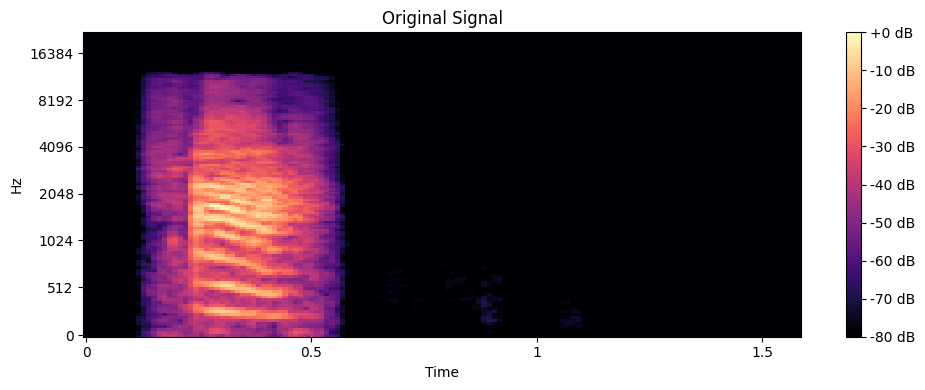

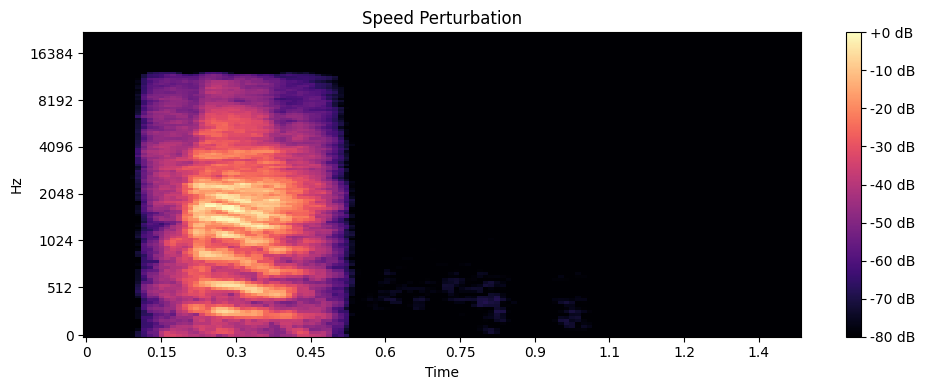

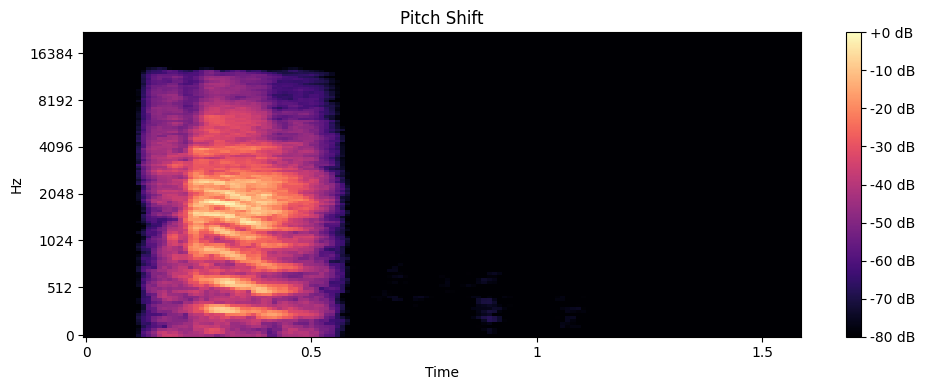

In [8]:
sample_audio_path = dataset_df[dataset_df['Phonics'] == 'a']['Path'].iloc[0]
data_sample, sr_sample = librosa.load(sample_audio_path, sr=None)

speed_aug = speed_perturb(data_sample, rate=1.1)
pitch_aug = pitch_shift(data_sample, sr=sr_sample, steps=1)

plot_spectrogram(data_sample, sr_sample, 'Original Signal')
plot_spectrogram(speed_aug, sr_sample, 'Speed Perturbation')
plot_spectrogram(pitch_aug, sr_sample, 'Pitch Shift')

# Ekstraksi Fitur

In [9]:
def extract_mfcc_for_cnn(y, sr, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T

def extract_mfcc_for_rnn(y, sr, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T

def extract_mfcc_for_transformer(y, sr, n_mfcc=20, max_frames=100):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T
    if len(mfcc) > max_frames:
        start = (len(mfcc) - max_frames) // 2
        return mfcc[start:start+max_frames]
    pad = max_frames - len(mfcc)
    return np.pad(mfcc, ((0, pad), (0, 0)), mode='reflect')

In [10]:
def speed_perturb(y, rate=1.1):
    return librosa.effects.time_stretch(y.astype(np.float32), rate=rate)

def pitch_shift(y, sr, n_steps=1):
    return librosa.effects.pitch_shift(y.astype(np.float32), sr=sr, n_steps=n_steps)

In [11]:
def extract_features(df, sr=22050, dur=3.0, n_mfcc=20, augment=True):
    cnn_f, rnn_f, tsf_f, labels = [], [], [], []
    for _, row in df.iterrows():
        try:
            y, _ = librosa.load(row['Path'], sr=sr, duration=dur)
            y = librosa.util.fix_length(y, size=int(sr * dur))
            y = librosa.util.normalize(y)

            versions = [y]
            if augment:
                versions.append(speed_perturb(y, 1.1))
                versions.append(pitch_shift(y, sr, 1))

            for v in versions:
                cnn_f.append(extract_mfcc_for_cnn(v, sr, n_mfcc))
                rnn_f.append(extract_mfcc_for_rnn(v, sr, n_mfcc))
                tsf_f.append(extract_mfcc_for_transformer(v, sr, n_mfcc))
                labels.append(row['Phonics'])
        except Exception as e:
            print(f"Error processing {row['Path']}: {e}")
    return {'cnn': cnn_f, 'rnn': rnn_f, 'tsf': tsf_f, 'labels': labels}


In [12]:
def pad_or_truncate(sequences, max_len=130):
    fixed = []
    for seq in sequences:
        if len(seq) > max_len:
            fixed.append(seq[:max_len])
        else:
            pad = max_len - len(seq)
            fixed.append(np.pad(seq, ((0, pad), (0, 0)), mode='constant'))
    return np.array(fixed)

In [13]:
def prepare_datasets(features):
    le = LabelEncoder()
    y = le.fit_transform(features['labels'])

    cnn = pad_or_truncate(features['cnn'], 130)
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(cnn, y, test_size=0.2, stratify=y)
    scaler_cnn = StandardScaler()
    X_train_cnn = scaler_cnn.fit_transform(X_train_cnn.reshape(-1, cnn.shape[-1])).reshape(X_train_cnn.shape)
    X_test_cnn = scaler_cnn.transform(X_test_cnn.reshape(-1, cnn.shape[-1])).reshape(X_test_cnn.shape)

    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(features['rnn'], y, test_size=0.2, stratify=y)
    scaler_rnn = StandardScaler().fit(np.vstack(X_train_rnn))
    X_train_rnn = [scaler_rnn.transform(x) for x in X_train_rnn]
    X_test_rnn = [scaler_rnn.transform(x) for x in X_test_rnn]

    X_train_tsf, X_test_tsf, y_train_tsf, y_test_tsf = train_test_split(features['tsf'], y, test_size=0.2, stratify=y)
    scaler_tsf = StandardScaler().fit(np.vstack(X_train_tsf))
    X_train_tsf = pad_or_truncate([scaler_tsf.transform(x) for x in X_train_tsf], max_len=100)
    X_test_tsf = pad_or_truncate([scaler_tsf.transform(x) for x in X_test_tsf], max_len=100)

    return {
        'cnn': (X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn),
        'rnn': (X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn),
        'tsf': (X_train_tsf, X_test_tsf, y_train_tsf, y_test_tsf),
        'label_encoder': le
    }

if __name__ == "__main__":
    features = extract_features(dataset_df)
    datasets = prepare_datasets(features)

In [15]:
def print_dataset_summary(data):
    print("CNN Dataset:")
    print(f"Train: {len(data['cnn'][0])} samples")
    print(f"Test : {len(data['cnn'][1])} samples\n")

    print("RNN Dataset:")
    print(f"Train: {len(data['rnn'][0])} samples")
    print(f"Test : {len(data['rnn'][1])} samples\n")

    print("Transformer Dataset:")
    print(f"Train: {len(data['tsf'][0])} samples")
    print(f"Test : {len(data['tsf'][1])} samples")

print_dataset_summary(datasets)

CNN Dataset:
Train: 2366 samples
Test : 592 samples

RNN Dataset:
Train: 2366 samples
Test : 592 samples

Transformer Dataset:
Train: 2366 samples
Test : 592 samples


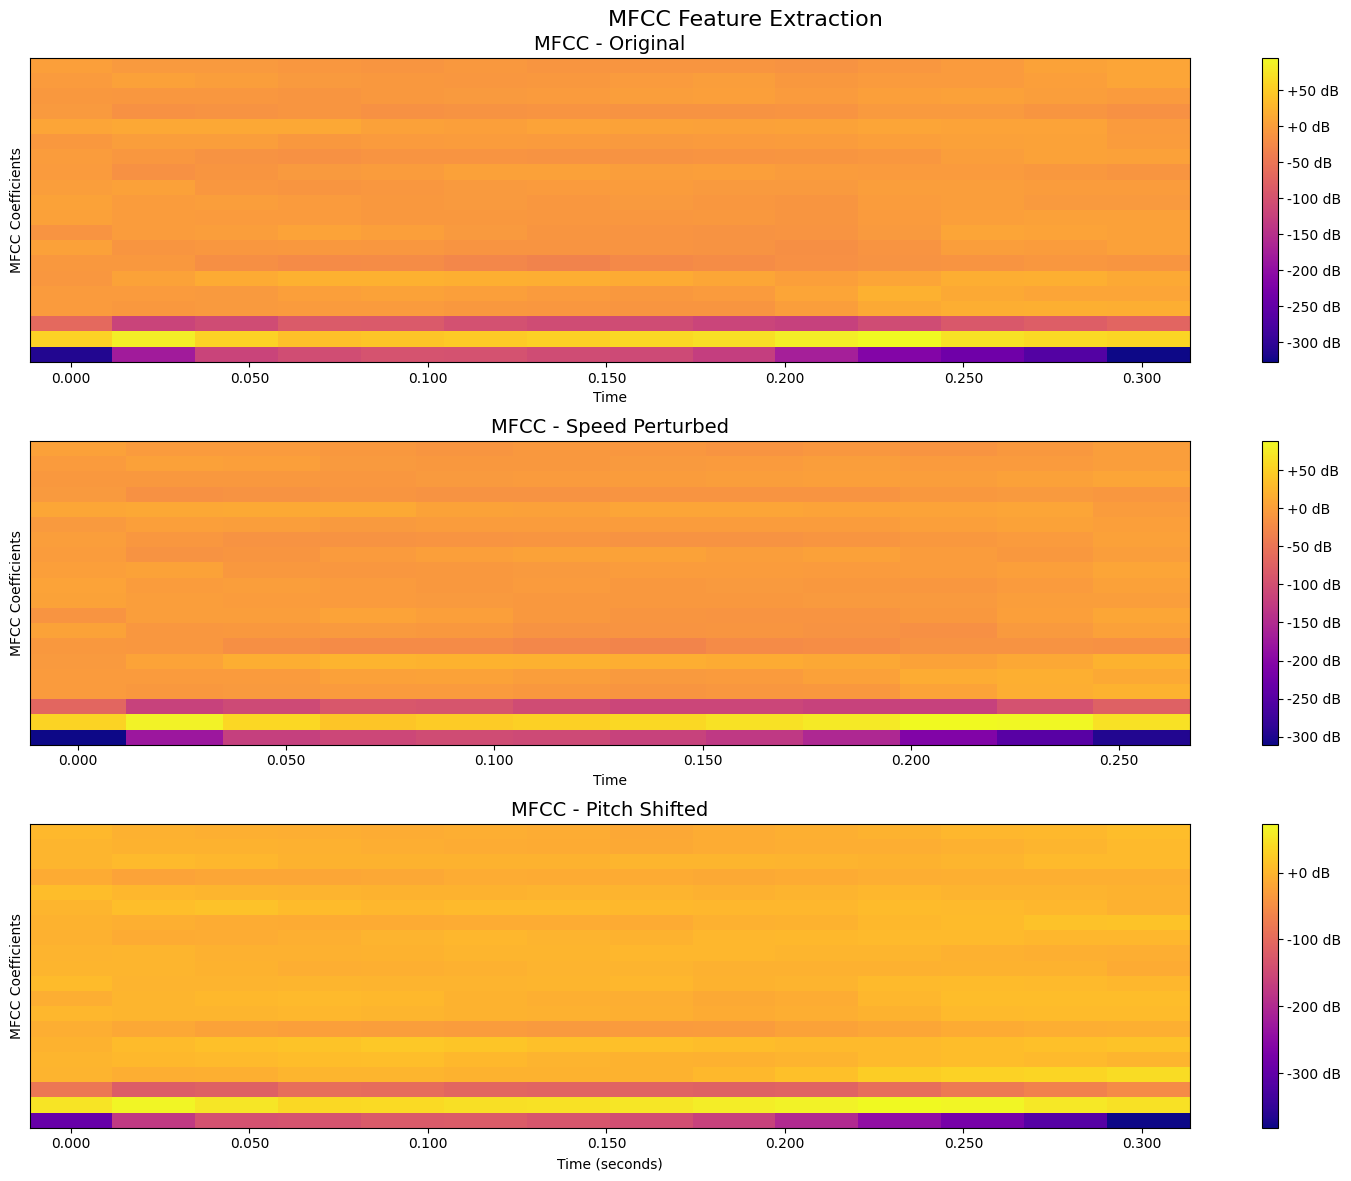

In [16]:
def extract_mfcc_for_cnn(y, sr, n_mfcc=20):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T

def speed_perturb(y, rate=1.1):
    return librosa.effects.time_stretch(y.astype(np.float32), rate=rate)

def pitch_shift(y, sr, n_steps=1):
    return librosa.effects.pitch_shift(y.astype(np.float32), sr=sr, n_steps=n_steps)

sample_audio_path = dataset_df[dataset_df['Phonics'] == 'a']['Path'].iloc[0]
original_data, sample_rate = librosa.load(sample_audio_path, sr=22050, duration=3.0)

original_data, _ = librosa.effects.trim(original_data, top_db=20)

speed_perturbed = speed_perturb(original_data, rate=1.1)
pitch_shifted = pitch_shift(original_data, sr=sample_rate, n_steps=1)

mfcc_original = extract_mfcc_for_cnn(original_data, sample_rate)
mfcc_speed = extract_mfcc_for_cnn(speed_perturbed, sample_rate)
mfcc_pitch = extract_mfcc_for_cnn(pitch_shifted, sample_rate)

# Transpose back for visualization
mfcc_original_disp = mfcc_original.T
mfcc_speed_disp = mfcc_speed.T
mfcc_pitch_disp = mfcc_pitch.T

plt.figure(figsize=(15, 12))
chosen_cmap = 'plasma'

plt.subplot(3, 1, 1)
librosa.display.specshow(mfcc_original_disp,
                        sr=sample_rate,
                        x_axis='time',
                        cmap=chosen_cmap)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC - Original', fontsize=14)
plt.ylabel('MFCC Coefficients')

plt.subplot(3, 1, 2)
librosa.display.specshow(mfcc_speed_disp,
                        sr=sample_rate,
                        x_axis='time',
                        cmap=chosen_cmap)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC - Speed Perturbed', fontsize=14)
plt.ylabel('MFCC Coefficients')

plt.subplot(3, 1, 3)
librosa.display.specshow(mfcc_pitch_disp,
                        sr=sample_rate,
                        x_axis='time',
                        cmap=chosen_cmap)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC - Pitch Shifted', fontsize=14)
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (seconds)')

plt.tight_layout()
plt.suptitle('MFCC Feature Extraction',
             fontsize=16, y=0.98)
plt.subplots_adjust(top=0.94)
plt.show()

# Classifier

# CNN

## 0.8919

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from torch.optim.lr_scheduler import CosineAnnealingLR
from skorch.helper import predefined_split
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch import NeuralNetClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\nReducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

class CNN_Classifier(nn.Module):
    def __init__(self, input_shape, num_classes, n_blocks, conv_params, dropout, fc_units=256, use_bn=True):
        super().__init__()
        self.blocks = nn.ModuleList()
        in_channels = input_shape[1]

        for i in range(n_blocks):
            out_channels = conv_params[i]['out_channels']
            kernel_size = conv_params[i]['kernel_size']
            pool_size = conv_params[i]['pool_size']
            block_dropout = conv_params[i]['dropout']

            block = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                SEBlock(out_channels),
                nn.MaxPool1d(pool_size),
                nn.Dropout(block_dropout)
            )
            self.blocks.append(block)
            in_channels = out_channels

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        classifier_layers = [nn.Linear(in_channels, fc_units)]
        if use_bn:
            classifier_layers.append(nn.BatchNorm1d(fc_units))
        classifier_layers.extend([
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_units, num_classes)
        ])
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = x.transpose(1, 2)
        for block in self.blocks:
            x = block(x)
        x = self.global_pool(x).squeeze(-1)
        return self.classifier(x)

def objective(trial, X_train, y_train, X_val, y_val, num_classes):
    n_blocks = trial.suggest_categorical('n_blocks', [2, 3, 4])
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    fc_units = trial.suggest_categorical('fc_units', [128, 256, 512])
    use_bn = trial.suggest_categorical('use_bn', [True, False])

    conv_params = []
    for i in range(n_blocks):
        conv_params.append({
            'out_channels': trial.suggest_categorical(f'channels_{i}', [64, 128, 256]),
            'kernel_size': trial.suggest_int(f'kernel_{i}', 3, 7, step=2),
            'pool_size': trial.suggest_int(f'pool_{i}', 1, 2),
            'dropout': trial.suggest_float(f'block_dropout_{i}', 0.1, 0.4)
        })

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=num_classes,
        n_blocks=n_blocks,
        conv_params=conv_params,
        dropout=dropout,
        fc_units=fc_units,
        use_bn=use_bn
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),
        batch_size=32, shuffle=True
    )

    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)),
        batch_size=32
    )

    scheduler = CosineAnnealingLR(optimizer, T_max=100)
    best_acc = 0

    for epoch in range(100):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        scheduler.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_acc = correct / total
        trial.report(val_acc, epoch)
        if val_acc > best_acc:
            best_acc = val_acc
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_acc

def train_cnn(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, X_val, y_val, len(label_encoder.classes_)),
        n_trials=50
    )

    best_params = study.best_trial.params
    print(f"\nBest hyperparameters: {best_params}")

    conv_params = []
    for i in range(best_params['n_blocks']):
        conv_params.append({
            'out_channels': best_params[f'channels_{i}'],
            'kernel_size': best_params[f'kernel_{i}'],
            'pool_size': best_params[f'pool_{i}'],
            'dropout': best_params[f'block_dropout_{i}']
        })

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_model = CNN_Classifier(
        input_shape=X_train.shape[1:],
        num_classes=len(label_encoder.classes_),
        n_blocks=best_params['n_blocks'],
        conv_params=conv_params,
        dropout=best_params['dropout'],
        fc_units=best_params['fc_units'],
        use_bn=best_params['use_bn']
    ).to(device)

    net = NeuralNetClassifier(
        best_model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device=device,
        callbacks=[
            AdaptiveEarlyStopping(patience=5),
            LRScheduler(CosineAnnealingLR, T_max=60),
            EpochScoring('accuracy', name='valid_acc')
        ],
        train_split=predefined_split(
            torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
        )
    )

    net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    y_pred = net.predict(X_test.astype(np.float32))
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    return net

if __name__ == "__main__":
    data = prepare_datasets(features)
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = data['cnn']
    label_encoder = data['label_encoder']
    best_model = train_cnn(X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn, label_encoder)

[I 2025-06-04 15:17:01,840] A new study created in memory with name: no-name-a9a2d62d-d934-4047-80e6-2d5aecbd77d4
[I 2025-06-04 15:17:57,492] Trial 0 finished with value: 0.8924050632911392 and parameters: {'n_blocks': 3, 'dropout': 0.2147694871682107, 'fc_units': 256, 'use_bn': False, 'channels_0': 128, 'kernel_0': 3, 'pool_0': 1, 'block_dropout_0': 0.23347873859301554, 'channels_1': 256, 'kernel_1': 5, 'pool_1': 2, 'block_dropout_1': 0.15458677833194967, 'channels_2': 64, 'kernel_2': 5, 'pool_2': 2, 'block_dropout_2': 0.15217252210603793}. Best is trial 0 with value: 0.8924050632911392.
[I 2025-06-04 15:18:45,759] Trial 1 finished with value: 0.8291139240506329 and parameters: {'n_blocks': 3, 'dropout': 0.4347041025164364, 'fc_units': 256, 'use_bn': False, 'channels_0': 128, 'kernel_0': 3, 'pool_0': 1, 'block_dropout_0': 0.22598247870596444, 'channels_1': 64, 'kernel_1': 3, 'pool_1': 1, 'block_dropout_1': 0.28540106201442694, 'channels_2': 128, 'kernel_2': 3, 'pool_2': 1, 'block_drop


Best hyperparameters: {'n_blocks': 2, 'dropout': 0.3309875389306141, 'fc_units': 128, 'use_bn': True, 'channels_0': 64, 'kernel_0': 5, 'pool_0': 2, 'block_dropout_0': 0.29612381583809544, 'channels_1': 256, 'kernel_1': 7, 'pool_1': 1, 'block_dropout_1': 0.13779898181880382}
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        2.8120       0.3165        2.3456  0.0010  0.4099
      2        2.2457       0.3966        2.0285  0.0010  0.4231
      3        1.9224       0.4451        1.7478  0.0010  0.4029
      4        1.6754       0.5485        1.5512  0.0010  0.4196
      5        1.4530       0.5696        1.4372  0.0010  0.4100
      6        1.2759       0.5570        1.3922  0.0010  0.4091
      7        1.1074       0.5865        1.3244  0.0010  0.4119
      8        0.9587       0.5992        1.2713  0.0010  0.4091
      9        0.8346       0.6392        1.1187  0.0010  0.4140
     10  

Accuracy : 0.8919
Precision: 0.9028
Recall   : 0.8918
F1 Score : 0.8910

Classification Report:
              precision    recall  f1-score   support

           a       0.71      0.91      0.80        22
           b       0.94      0.74      0.83        23
           c       0.70      0.61      0.65        23
           d       0.91      0.95      0.93        22
           e       0.95      0.78      0.86        23
           f       0.96      1.00      0.98        23
           g       0.83      0.87      0.85        23
           h       0.81      0.96      0.88        23
           i       0.85      1.00      0.92        23
           j       0.96      0.96      0.96        23
           k       0.70      0.70      0.70        23
           l       0.95      0.78      0.86        23
           m       0.85      1.00      0.92        23
           n       1.00      0.73      0.84        22
           o       0.82      1.00      0.90        23
           p       0.70      1.00      

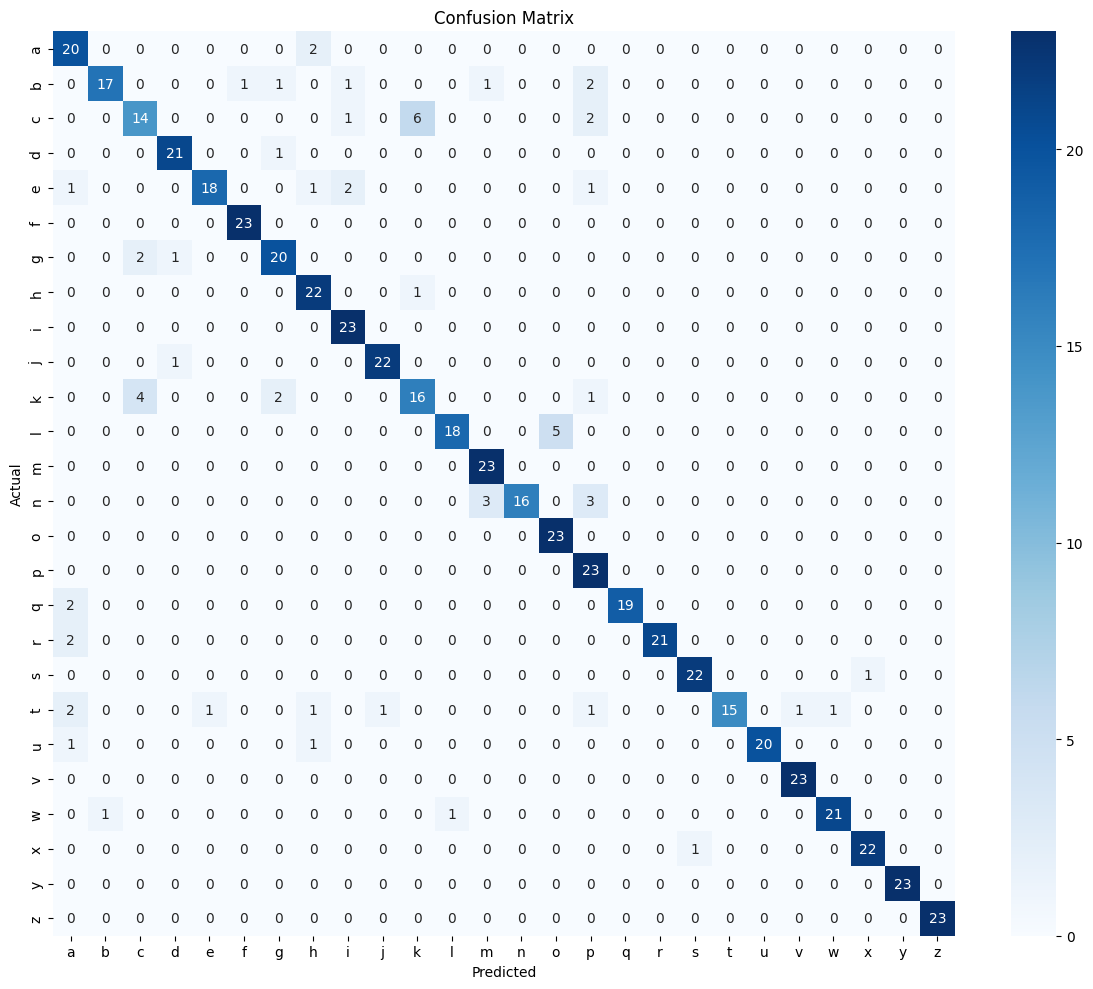

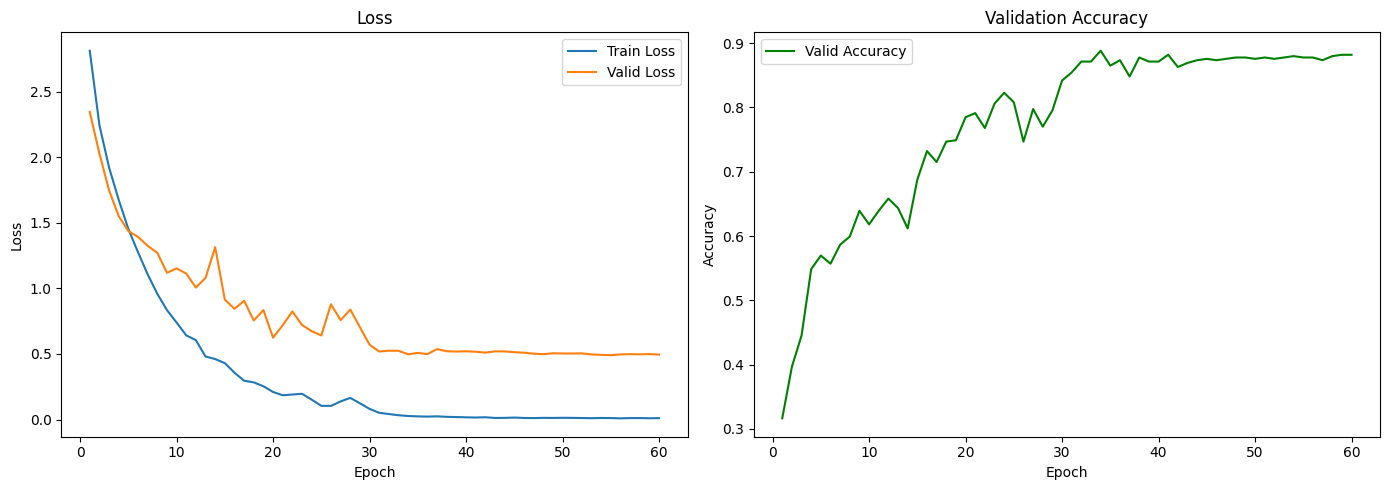

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs+1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs+1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs+1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
evaluate_model(best_model, X_test_cnn, y_test_cnn, label_encoder)
plot_training_history(best_model)


# RNN

## 0.9291

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import CosineAnnealingLR
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring, Callback
from skorch.helper import predefined_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os, contextlib

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class RNN_GRU(nn.Module):
    def __init__(self, input_dim, num_classes,
                 gru_hidden_size=320, num_layers=2,
                 attention_heads=4, dense_size=512,
                 dropout=0.3, bidirectional=True,
                 activation_fn='mish'):
        super().__init__()

        self.activation = (
            nn.ReLU() if activation_fn == 'relu'
            else nn.GELU() if activation_fn == 'gelu'
            else nn.Mish()
        )

        self.gru = nn.GRU(
            input_dim,
            gru_hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.attention = nn.MultiheadAttention(
            embed_dim=gru_hidden_size * (2 if bidirectional else 1),
            num_heads=attention_heads,
            dropout=dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(gru_hidden_size * (2 if bidirectional else 1), dense_size),
            self.activation,
            nn.LayerNorm(dense_size),
            nn.Dropout(dropout),
            nn.Linear(dense_size, num_classes)
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)
        attn_out, _ = self.attention(gru_out, gru_out, gru_out)
        pooled = attn_out.mean(dim=1)
        return self.classifier(pooled)

def gru_optuna(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    X_train_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_train]
    X_val_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_val]
    X_test_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_test]

    X_train_pad = pad_sequence(X_train_tensor, batch_first=True).numpy()
    X_val_pad = pad_sequence(X_val_tensor, batch_first=True).numpy()
    X_test_pad = pad_sequence(X_test_tensor, batch_first=True).numpy()

    def objective(trial):
        input_dim = X_train_pad.shape[-1]
        num_classes = len(label_encoder.classes_)

        model = RNN_GRU(
            input_dim=input_dim,
            num_classes=num_classes,
            gru_hidden_size=trial.suggest_categorical('gru_hidden_size', [256, 320, 384]),
            num_layers=trial.suggest_int('num_layers', 1, 3),
            attention_heads=trial.suggest_categorical('attention_heads', [2, 4, 8]),
            dense_size=trial.suggest_categorical('dense_size', [384, 512, 640]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            bidirectional=trial.suggest_categorical('bidirectional', [True, False]),
            activation_fn=trial.suggest_categorical('activation_fn', ['relu', 'gelu', 'mish'])
        )

        net = NeuralNetClassifier(
            module=model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(
                torch.utils.data.TensorDataset(
                    torch.FloatTensor(X_val_pad),
                    torch.LongTensor(y_val)
                )
            ),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=60)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)
    )
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_params)

    best_params = study.best_params
    input_dim = X_train_pad.shape[-1]
    num_classes = len(label_encoder.classes_)

    final_model = RNN_GRU(
        input_dim=input_dim,
        num_classes=num_classes,
        gru_hidden_size=best_params['gru_hidden_size'],
        num_layers=best_params['num_layers'],
        attention_heads=best_params['attention_heads'],
        dense_size=best_params['dense_size'],
        dropout=best_params['dropout'],
        bidirectional=best_params['bidirectional'],
        activation_fn=best_params['activation_fn']
    )

    final_net = NeuralNetClassifier(
        final_model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(label_smoothing=0.1),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(
            torch.utils.data.TensorDataset(
                torch.FloatTensor(X_val_pad),
                torch.LongTensor(y_val)
            )
        ),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train_pad.astype(np.float32), np.array(y_train).astype(np.longlong))
    y_pred = final_net.predict(X_test_pad.astype(np.float32))
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return final_net

if __name__ == "__main__":
    data = prepare_datasets(features)
    X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = data['rnn']
    label_encoder = data['label_encoder']
    best_model = gru_optuna(X_train_rnn, y_train_rnn, X_test_rnn, y_test_rnn, label_encoder)

[I 2025-06-04 15:31:20,969] A new study created in memory with name: no-name-301b5113-eecb-4ca1-9d58-42cfde3b845b


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-06-04 15:31:55,563] Trial 0 finished with value: 0.9092827004219409 and parameters: {'gru_hidden_size': 320, 'num_layers': 1, 'attention_heads': 8, 'dense_size': 384, 'dropout': 0.2, 'bidirectional': False, 'activation_fn': 'relu'}. Best is trial 0 with value: 0.9092827004219409.
[I 2025-06-04 15:32:42,524] Trial 1 finished with value: 0.9324894514767933 and parameters: {'gru_hidden_size': 256, 'num_layers': 2, 'attention_heads': 4, 'dense_size': 384, 'dropout': 0.25, 'bidirectional': False, 'activation_fn': 'relu'}. Best is trial 1 with value: 0.9324894514767933.
[I 2025-06-04 15:33:39,542] Trial 2 finished with value: 0.919831223628692 and parameters: {'gru_hidden_size': 384, 'num_layers': 1, 'attention_heads': 4, 'dense_size': 640, 'dropout': 0.25, 'bidirectional': True, 'activation_fn': 'mish'}. Best is trial 1 with value: 0.9324894514767933.
[I 2025-06-04 15:34:26,444] Trial 3 finished with value: 0.9345991561181435 and parameters: {'gru_hidden_size': 320, 'num_layers': 2,


Evaluation Metrics:
Accuracy : 0.9291
Precision: 0.9313
Recall   : 0.9290
F1 Score : 0.9289

Classification Report:
              precision    recall  f1-score   support

           a       0.95      0.87      0.91        23
           b       1.00      0.91      0.95        22
           c       0.87      0.87      0.87        23
           d       0.78      0.78      0.78        23
           e       0.96      0.96      0.96        23
           f       1.00      1.00      1.00        23
           g       0.90      0.86      0.88        22
           h       0.92      1.00      0.96        22
           i       0.92      0.96      0.94        23
           j       0.88      1.00      0.94        23
           k       0.75      0.78      0.77        23
           l       1.00      0.96      0.98        23
           m       1.00      1.00      1.00        23
           n       1.00      0.96      0.98        23
           o       0.88      1.00      0.94        23
           p      

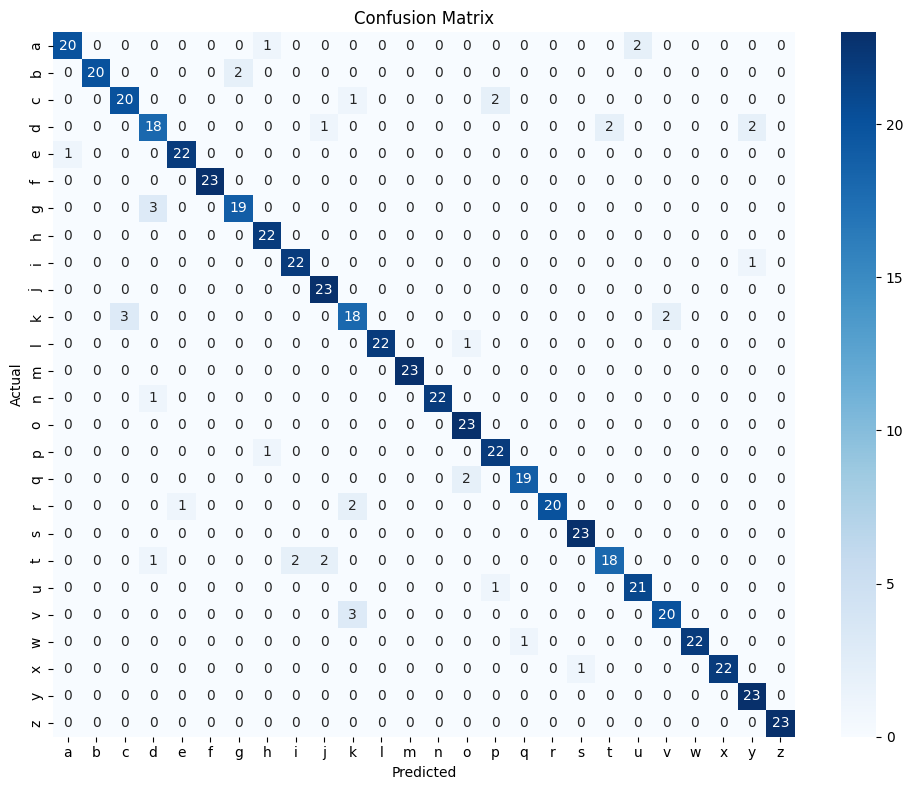

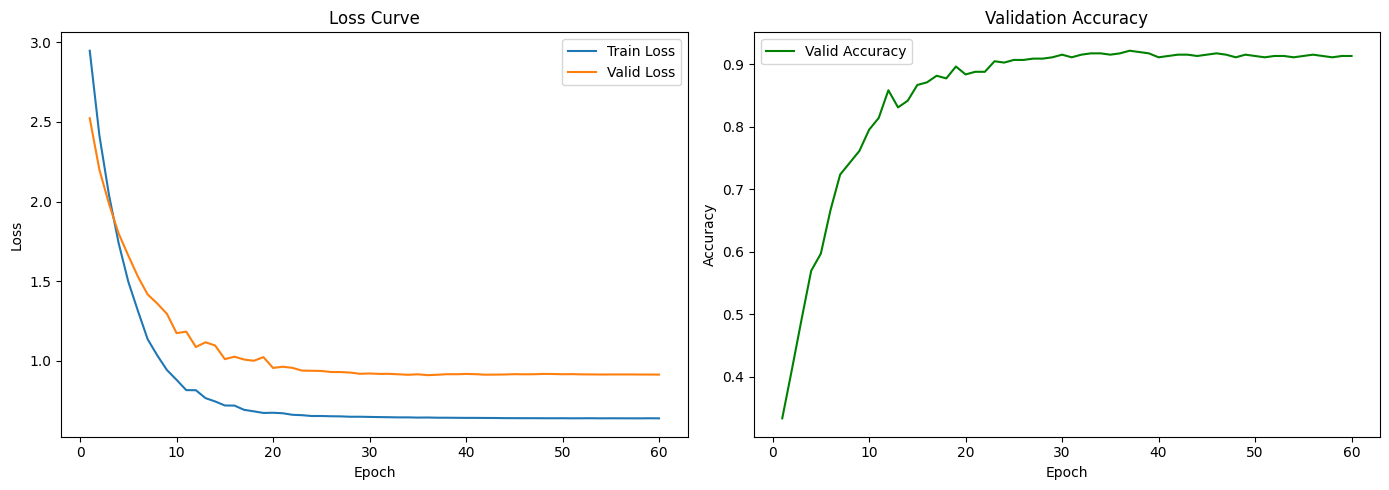

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.utils.rnn import pad_sequence

def evaluate_model(model, X_test_raw, y_test, label_encoder):
    # Ensure padded input
    X_test_tensor = [torch.tensor(x, dtype=torch.float32) for x in X_test_raw]
    X_test_pad = pad_sequence(X_test_tensor, batch_first=True).numpy()

    # Predict
    y_pred = model.predict(X_test_pad.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs + 1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs + 1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss Curve')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs + 1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

evaluate_model(best_model, X_test_rnn, y_test_rnn, label_encoder)
plot_training_history(best_model)

# Tranformers

## 0.8125

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import optuna
import math
import os
import contextlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset
from skorch import NeuralNetClassifier
from skorch.callbacks import Callback, LRScheduler, EpochScoring
from skorch.helper import predefined_split

class AdaptiveEarlyStopping(Callback):
    def __init__(self, patience=5, threshold=0.001):
        self.patience = patience
        self.threshold = threshold
        self.best_score = -np.inf
        self.wait = 0

    def on_epoch_end(self, net, **kwargs):
        current_score = net.history[-1]['valid_acc']
        if current_score - self.best_score > self.threshold:
            self.best_score = current_score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = net.optimizer_.param_groups[0]['lr']
                new_lr = old_lr * 0.5
                print(f"\n[LR Reduction] Reducing LR from {old_lr:.2e} to {new_lr:.2e}")
                for param_group in net.optimizer_.param_groups:
                    param_group['lr'] = new_lr
                self.wait = 0

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()
        self.max_len = max_len
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        if seq_len > self.max_len:
            raise ValueError(f"Input sequence length {seq_len} exceeds maximum {self.max_len}")
        return x + self.pe[:seq_len, :]

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_layers, nhead, d_model, dim_feedforward, dropout, dense, activation, max_len):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation=activation,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, dense),
            nn.ReLU(),
            nn.LayerNorm(dense),
            nn.Dropout(dropout),
            nn.Linear(dense, num_classes)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.classifier(x)

def train_transformer(X_train, y_train, X_test, y_test, label_encoder):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    max_seq_len = X_train.shape[1]

    def objective(trial):
        d_model = trial.suggest_categorical('d_model', [64, 128, 256])
        valid_heads = [h for h in [2, 4, 8] if d_model % h == 0]
        if not valid_heads:
            raise optuna.exceptions.TrialPruned()

        model = TransformerClassifier(
            input_dim=X_train.shape[-1],
            num_classes=len(label_encoder.classes_),
            num_layers=trial.suggest_int('num_layers', 2, 4),
            nhead=trial.suggest_categorical('nhead', valid_heads),
            d_model=d_model,
            dim_feedforward=trial.suggest_categorical('dim_feedforward', [256, 512, 1024]),
            dropout=trial.suggest_float('dropout', 0.2, 0.4, step=0.05),
            dense=trial.suggest_categorical('dense', [128, 256, 512]),
            activation=trial.suggest_categorical('activation', ['relu', 'gelu']),
            max_len=max_seq_len
        )

        net = NeuralNetClassifier(
            model,
            max_epochs=60,
            batch_size=32,
            optimizer=torch.optim.AdamW,
            optimizer__lr=0.001,
            criterion=nn.CrossEntropyLoss(),
            device='cuda' if torch.cuda.is_available() else 'cpu',
            train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
            callbacks=[
                ('adapt', AdaptiveEarlyStopping(patience=5)),
                ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
                ('score', EpochScoring('accuracy', name='valid_acc'))
            ],
            verbose=0
        )

        with open(os.devnull, 'w') as devnull:
            with contextlib.redirect_stdout(devnull):
                net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))

        for epoch, acc in enumerate(net.history[:, 'valid_acc']):
            trial.report(acc, step=epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        return max(net.history[:, 'valid_acc'])

    study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("\nBest hyperparameters:")
    print(study.best_trial.params)

    best_params = study.best_trial.params
    model = TransformerClassifier(
        input_dim=X_train.shape[-1],
        num_classes=len(label_encoder.classes_),
        **best_params,
        max_len=max_seq_len
    )

    final_net = NeuralNetClassifier(
        model,
        max_epochs=60,
        batch_size=32,
        optimizer=torch.optim.AdamW,
        optimizer__lr=0.001,
        criterion=nn.CrossEntropyLoss(),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        train_split=predefined_split(TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))),
        callbacks=[
            ('adapt', AdaptiveEarlyStopping(patience=5)),
            ('sched', LRScheduler(CosineAnnealingLR, T_max=80)),
            ('score', EpochScoring('accuracy', name='valid_acc'))
        ],
        verbose=1
    )

    final_net.fit(X_train.astype(np.float32), y_train.astype(np.longlong))
    y_pred = final_net.predict(X_test.astype(np.float32))
    print("\nFinal Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    return final_net, X_test, y_test, label_encoder

X_train_tsf, X_test_tsf, y_train_tsf, y_test_tsf = data['tsf']
label_encoder = data['label_encoder']
model = train_transformer(X_train_tsf, y_train_tsf, X_test_tsf, y_test_tsf, label_encoder)

[I 2025-06-05 14:29:50,296] A new study created in memory with name: no-name-d444f438-0e19-4559-80a9-4b747a864cf3


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-05 14:30:40,453] Trial 0 finished with value: 0.43248945147679324 and parameters: {'d_model': 256, 'num_layers': 4, 'nhead': 4, 'dim_feedforward': 512, 'dropout': 0.30000000000000004, 'dense': 128, 'activation': 'gelu'}. Best is trial 0 with value: 0.43248945147679324.
[I 2025-06-05 14:31:16,630] Trial 1 finished with value: 0.8248945147679325 and parameters: {'d_model': 128, 'num_layers': 3, 'nhead': 2, 'dim_feedforward': 256, 'dropout': 0.25, 'dense': 128, 'activation': 'relu'}. Best is trial 1 with value: 0.8248945147679325.
[I 2025-06-05 14:32:01,834] Trial 2 finished with value: 0.23628691983122363 and parameters: {'d_model': 256, 'num_layers': 4, 'nhead': 8, 'dim_feedforward': 1024, 'dropout': 0.4, 'dense': 512, 'activation': 'gelu'}. Best is trial 1 with value: 0.8248945147679325.
[I 2025-06-05 14:32:38,149] Trial 3 finished with value: 0.6814345991561181 and parameters: {'d_model': 256, 'num_layers': 3, 'nhead': 4, 'dim_feedforward': 1024, 'dropout': 0.35000000000000

Accuracy : 0.8125
Precision: 0.8223
Recall   : 0.8124
F1 Score : 0.8126

Classification Report:
              precision    recall  f1-score   support

           a       0.90      0.78      0.84        23
           b       0.76      0.70      0.73        23
           c       0.55      0.55      0.55        22
           d       0.71      0.74      0.72        23
           e       0.92      0.96      0.94        23
           f       0.90      0.78      0.84        23
           g       0.79      0.83      0.81        23
           h       0.95      0.78      0.86        23
           i       0.95      0.87      0.91        23
           j       0.73      0.83      0.78        23
           k       0.54      0.57      0.55        23
           l       0.94      0.74      0.83        23
           m       0.91      0.91      0.91        23
           n       0.77      0.87      0.82        23
           o       0.72      0.95      0.82        22
           p       0.81      0.74      

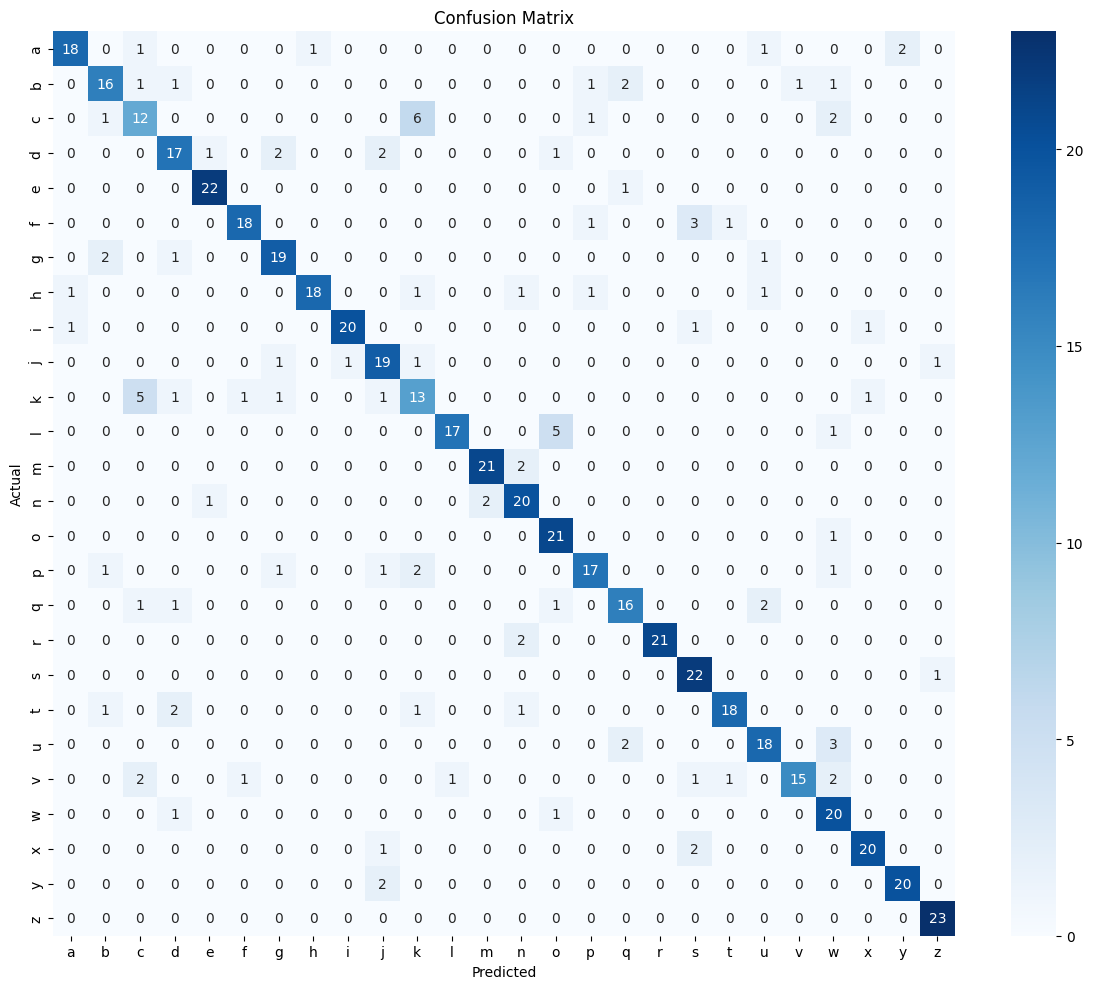

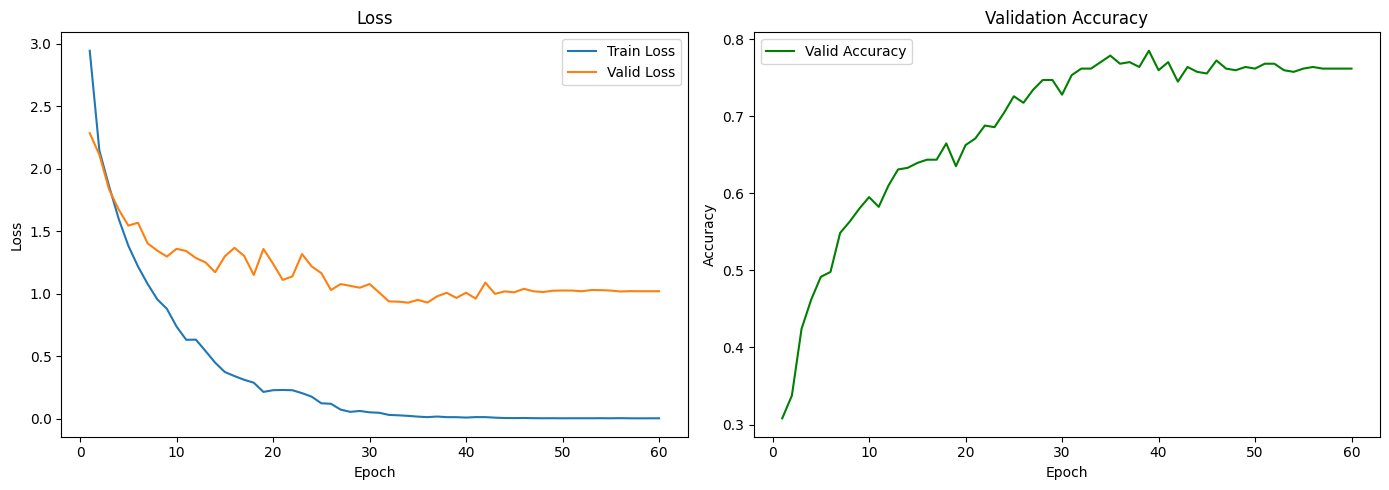

In [ ]:
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_encoder):
    y_pred = model.predict(X_test.astype(np.float32))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_training_history(model):
    history = model.history
    epochs = len(history)

    train_loss = history[:, 'train_loss']
    val_loss = history[:, 'valid_loss']
    val_acc = history[:, 'valid_acc']

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(range(1, epochs + 1), train_loss, label='Train Loss')
    ax[0].plot(range(1, epochs + 1), val_loss, label='Valid Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(range(1, epochs + 1), val_acc, label='Valid Accuracy', color='green')
    ax[1].set_title('Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

transformer_model, X_test_tsf_eval, y_test_tsf_eval, label_encoder_eval = model
evaluate_model(transformer_model, X_test_tsf_eval, y_test_tsf_eval, label_encoder_eval)
plot_training_history(transformer_model)